<a href="https://colab.research.google.com/github/adamzbikowski/Process-Mining-Dissertation/blob/main/activity_pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pipeline 1: predicting missing values for activity

##Section 0: Customisation

**Note on usage:**
To customise the pipeline, only alter the parameters in this section.

In [153]:
# The following parameters can be customised:

# change depending on which branch the queries have been pushed to
BRANCH = "sql-queries" 

# change this to change which query is being used
QUERY_NAME = "el_hypertension.sql"

# this assumes that the user has access to the mimic-iii dataset
# through google BigQuery
# replace project name to the project containing mimic-iii
PROJECT_NAME = "processmining-367815" 

# change to alter the number of random traces being selected
# set value to None in order to use the full dataset
NUM_TRACES = 1000

# IGNORE if event log does not include procedures
# set to false if  
CATEGORICAL_PROCEDURES = False

# change to alter the prefix/suffix length
PREFIX_LENGTH = 5

# change to alter the size of the test and validation sets
TEST_SIZE = 0.2
VALIDATION_SIZE = 0.2

# change to tune hyperparameters






## Section 1: Loading event log

###1.1

In [116]:
# installing prerequisites
# certain packages are not installed by default on google colab
!pip install pm4py
!pip install -q -U keras-tuner

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [123]:
from google.colab import auth
auth.authenticate_user()

In [118]:

from google.cloud import bigquery
client = bigquery.Client(project=PROJECT_NAME)

In [124]:
import requests

# read a query from the github repository
url = f"https://raw.githubusercontent.com/adamzbikowski/Process-Mining-Dissertation/{BRANCH}/sql_queries/{QUERY_NAME}"
query_bytes = requests.get(url).content

# we must now decode this to turn the query into a string 
query = query_bytes.decode("utf-8")

###1.2

In [125]:
import pandas as pd

# loading event log from mimic-iii using bigQuery
event_log = client.query(query).to_dataframe()
# convert timestamp from object to datetime64
event_log["timestamp"] = pd.to_datetime(event_log["timestamp"])
event_log


,patient,activity,timestamp
0,199270,Left ICU,2136-08-04 18:50:08
1,112156,Left ICU,2132-10-26 21:47:01
2,185179,Left ICU,2169-07-31 13:41:16
3,178795,Left ICU,2147-09-18 17:26:50
4,157527,Left ICU,2138-05-17 18:58:53
...,...,...,...
84433,182505,Discharged,2108-12-17 13:27:00
84434,193195,Discharged,2109-05-30 11:40:00
84435,110458,Discharged,2171-06-08 11:30:00
84436,120514,Discharged,2163-09-09 17:30:00


## Section 2: Process Discovery

In [126]:
import pm4py as pm

event_log = pm.format_dataframe(event_log, case_id='patient', activity_key='activity', timestamp_key='timestamp')
# lets get some information about the event log
n_events = len(event_log)
n_cases = len(event_log.patient.unique())
start_events = pm.get_start_activities(event_log)
end_events = pm.get_end_activities(event_log)
print(f"Number of cases: {n_cases}\nNumber of events: {n_events}")
print(f"Start events: {start_events}\nEnd events: {end_events}")


<ipython-input-126-aedec179434f>:3: DeprecatedWarning: format_dataframe is deprecated as of 2.3.0 and will be removed in 3.0.0. the format_dataframe function does not need application anymore.
  event_log = pm.format_dataframe(event_log, case_id='patient', activity_key='activity', timestamp_key='timestamp')


Number of cases: 20696
Number of events: 84438
Start events: {'Admitted': 20321, 'Entered ICU': 352, 'Discharged': 23}
End events: {'Discharged': 17501, 'Left ICU': 3193, 'Admitted': 2}


In [127]:
# lets improve the event log by filtering out the cases that do not start or end with a patient being admitted or discharged
# this will simplify the model
# filtered_log = deepcopy(event_log)
event_log = pm.filter_start_activities(event_log, ['Admitted'])
event_log = pm.filter_end_activities(event_log,['Discharged'])
# event_log = pm.filter_variants_top_k(event_log,50)
# event_log = pm.filter_variants_by_coverage_percentage(event_log, 0.1)

In [128]:
n_events = len(event_log)
n_cases = len(event_log.patient.unique())
start_events = pm.get_start_activities(event_log)
end_events = pm.get_end_activities(event_log)
print(f"Number of cases: {n_cases}\nNumber of events: {n_events}")
print(f"Start events: {start_events}\nEnd events: {end_events}")

Number of cases: 17163
Number of events: 69708
Start events: {'Admitted': 17163}
End events: {'Discharged': 17163}


In [129]:
net, initial_marking, final_marking = pm.discover_petri_net_alpha(event_log)

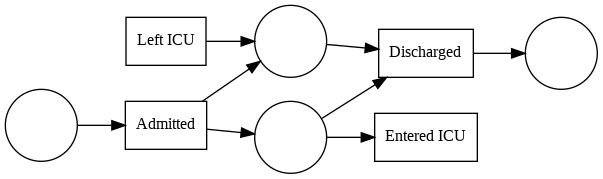

In [130]:
import graphviz
pm.view_petri_net(petri_net=net)

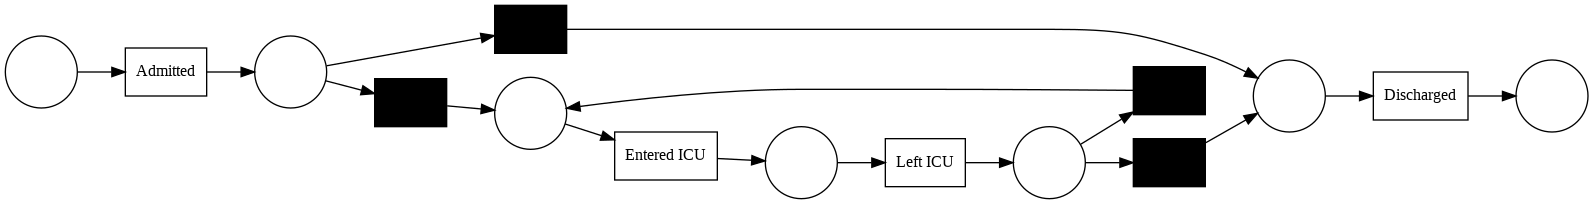

In [131]:
# inductive miner
# much better result than when using alpha miner, petri net 
net, initial_marking, final_marking = pm.discover_petri_net_inductive(event_log)
pm.view_petri_net(petri_net=net)

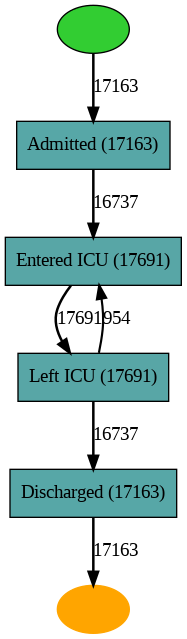

In [132]:
# heuristic miner
heu_net = pm.discover_heuristics_net(event_log, dependency_threshold=0.99)
pm.view_heuristics_net(heu_net)

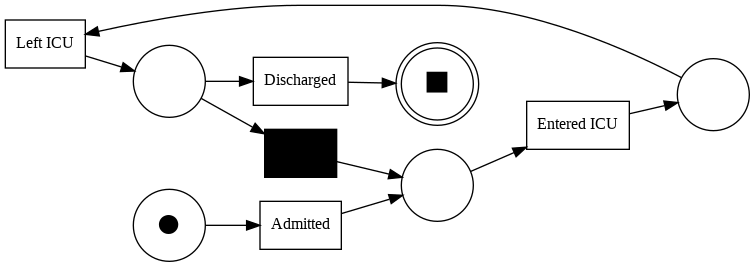

In [133]:
# petri net from heuristics miner
net, im, fm = pm.discover_petri_net_heuristics(event_log, dependency_threshold=0.99)
pm.view_petri_net(net, im, fm)

## Section 3: Data Pre Processing



In [154]:
from pandas.core.window.ewm import partial
import random

def partial_log(el, n):

  # select the first n cases to test the LSTM methodology
  # lets first add a trace column to the event_log
  el['trace'] = el.groupby(['patient']).ngroup()
  el = el[['trace', 'activity', 'timestamp' ]].reset_index(drop=True)
  # if n is None, return full event log
  if n is None:
    return el

  # initialise random seed and array of traces
  random.seed(9)
  random_traces = []

  for i in range(0,n):
    random_traces.append(random.randrange(0,n_cases))

  partial_el = event_log[event_log['trace'].isin(random_traces)]
  return partial_el


In [155]:
partial_el = partial_log(event_log, NUM_TRACES)
partial_el

,patient,activity,timestamp,case:concept:name,concept:name,time:timestamp,@@index,@@case_index,start_timestamp,trace
76,100085,Admitted,2126-08-30 07:15:00,100085,Admitted,2126-08-30 07:15:00,76,18,2126-08-30 07:15:00,18
77,100085,Entered ICU,2126-08-30 14:04:01,100085,Entered ICU,2126-08-30 14:04:01,77,18,2126-08-30 14:04:01,18
78,100085,Left ICU,2126-08-31 17:25:41,100085,Left ICU,2126-08-31 17:25:41,78,18,2126-08-31 17:25:41,18
79,100085,Discharged,2126-09-08 14:45:00,100085,Discharged,2126-09-08 14:45:00,79,18,2126-09-08 14:45:00,18
84,100094,Admitted,2109-06-06 10:21:00,100094,Admitted,2109-06-06 10:21:00,84,20,2109-06-06 10:21:00,20
...,...,...,...,...,...,...,...,...,...,...
84393,199947,Entered ICU,2109-06-25 17:01:42,199947,Entered ICU,2109-06-25 17:01:42,84393,20686,2109-06-25 17:01:42,17153
84394,199947,Left ICU,2109-06-29 18:08:59,199947,Left ICU,2109-06-29 18:08:59,84394,20686,2109-06-29 18:08:59,17153
84395,199947,Entered ICU,2109-07-01 10:15:01,199947,Entered ICU,2109-07-01 10:15:01,84395,20686,2109-07-01 10:15:01,17153
84396,199947,Left ICU,2109-07-05 18:06:14,199947,Left ICU,2109-07-05 18:06:14,84396,20686,2109-07-05 18:06:14,17153


In [156]:
if QUERY_NAME != 'el_procedures_2.sql':
  CATEGORICAL_PROCEDURES = False

if CATEGORICAL_PROCEDURES == False:
    
  # lets represent each activity using a statically defined number
  # this will prevent the need for using an embedding layer when traing the LSTM
  unique_activities = partial_el['activity'].unique()
  n_activities = len(unique_activities) + 1
  encode_activity = {unique_activities[i-1] : f'{i}' for i in range(1,n_activities)}

  # lets also create a second dictionary that will be used to decode predicted activities
  decode_activity = {f'{i}' : unique_activities[i-1] for i in range(1, len(unique_activities)+ 1)}

else:
  encode_activity = {
      'Admitted': '1',
      'Transfer': '2',
      'Entered ICU': '3',
      'Left ICU': '4',
      'Discharged': '5',
      'Peripheral Lines': '6',
      'Invasive Lines': '6',
      'Imaging': '7',
      'Ventilation': '8',
      'Intubation/Extubation': '8',
      'Procedures': '9',
      'Continuous Procedures': '9',
      'Significant Events': '10',
      'Dialysis': '11',
      'CRRT Filter Change': '11',
      'Peritoneal Dialysis': '11',
      'Communication': '12'
  }
  decode_activity = {}

encode_activity, decode_activity

({'Admitted': '1', 'Entered ICU': '2', 'Left ICU': '3', 'Discharged': '4'},
 {'1': 'Admitted', '2': 'Entered ICU', '3': 'Left ICU', '4': 'Discharged'})

In [157]:
# calculate time deltas for prefix and suffix sequences
def calculate_time_deltas(p, s):
  p_deltas, s_deltas = [], []
  f = '%Y-%d-%m %H:%M:%S'
  for i in range(PREFIX_LENGTH):
    if p[i] == '0' or p[i+1] == '0':
      p_deltas.append(0)

    else:
      delta = pd.to_datetime(p[i+1], format=f) - pd.to_datetime(p[i], format=f)
      p_deltas.append(delta.total_seconds())

  for i in range(PREFIX_LENGTH,0,-1):
    if s[i] == '0' or s[i-1] == '0':
      s_deltas.append(0)
    else:
      delta = pd.to_datetime(s[i], format=f) - pd.to_datetime(s[i-1], format=f)
      s_deltas.append(delta.total_seconds())
  
  return p_deltas, s_deltas[::-1]

In [158]:
import numpy as np

# create a new labeled data frame
def label(el):
  # initialise data frame 
 
  prefix_arr, suffix_arr, prefix_times_arr, suffix_times_arr, label_arr = [], [], [], [], []
  labeled_arr = []
  unique_traces = el['trace'].unique()
  traces = {x : pd.DataFrame() for x in unique_traces} 

  for t in unique_traces:
    traces[t] = el[:][el.trace == t]  
  
  for t in unique_traces:
    df = traces[t].sort_values(by='timestamp')
    activities, timestamps = [], []

    for i in df.index:
      activity = encode_activity.get(df['activity'][i])
      activities.append(activity)

      timestamp = df['timestamp'][i]
      timestamps.append(timestamp)

    
    length = len(activities)
    
    for i in range(length):

      label = activities[i]
      prefix = activities[:i]
      prefix_times = timestamps[:i+1]

      suffix = []
      suffix_times = []

      if i != length - 1:
        suffix = activities[i+1:]

      if i != length:
        suffix_times = timestamps[i:]

      padding = []

      while len(prefix) + len(padding) < PREFIX_LENGTH:
        padding.append('0')
      
      prefix = padding + prefix
        
      padding = []
      
      while len(prefix_times) + len(padding) < PREFIX_LENGTH+1:
        padding.append('0')
      
      prefix_times =  padding + prefix_times

      while len(suffix) < PREFIX_LENGTH:
        suffix.append('0')

      while len(suffix_times) < PREFIX_LENGTH +1:
        suffix_times.append('0')

      prefix_deltas, suffix_deltas = calculate_time_deltas(prefix_times, suffix_times)
      # print(f'prefix t: {prefix_times} \n suffix t: {suffix_times}')

      prefix_arr.append(np.array(prefix[0:PREFIX_LENGTH], dtype=int))
      suffix_arr.append(np.array(suffix[0:PREFIX_LENGTH], dtype=int))
      prefix_times_arr.append(np.array(prefix_deltas))
      suffix_times_arr.append(np.array(suffix_deltas))
      label_arr.append(label)

  return pd.DataFrame({'prefix' : prefix_arr, 
                       'suffix' : suffix_arr,
                       'prefix time delta' : prefix_times_arr,
                       'suffix time delta' : suffix_times_arr,
                       'label' : label_arr})
 

In [159]:
from sklearn.model_selection import train_test_split

# label event log
labeled_el = label(partial_el)

# split event log into a train and test set  
train_el, test_el  = train_test_split(labeled_el, test_size=TEST_SIZE, random_state=9)
train_el


,prefix,suffix,prefix time delta,suffix time delta,label
1413,"[0, 0, 0, 0, 1]","[3, 4, 0, 0, 0]","[0.0, 0.0, 0.0, 0.0, 60.0]","[691980.0, 443940.0, 0.0, 0.0, 0.0]",2
1615,"[0, 0, 1, 2, 3]","[0, 0, 0, 0, 0]","[0.0, 0.0, 74.0, 344373.0, 606373.0]","[0, 0, 0, 0, 0]",4
333,"[0, 0, 0, 0, 1]","[3, 4, 0, 0, 0]","[0.0, 0.0, 0.0, 0.0, 328840.0]","[116823.0, 345317.0, 0.0, 0.0, 0.0]",2
1148,"[0, 0, 0, 1, 2]","[4, 0, 0, 0, 0]","[0.0, 0.0, 0.0, 214.0, 149651.0]","[342435.0, 0.0, 0.0, 0.0, 0.0]",3
3429,"[0, 0, 1, 2, 3]","[0, 0, 0, 0, 0]","[0.0, 0.0, 32.0, 686666.0, 221822.0]","[0, 0, 0, 0, 0]",4
...,...,...,...,...,...
2104,"[0, 0, 0, 1, 2]","[4, 0, 0, 0, 0]","[0.0, 0.0, 0.0, 60.0, 187754.0]","[238486.0, 0.0, 0.0, 0.0, 0.0]",3
501,"[0, 0, 0, 0, 1]","[3, 4, 0, 0, 0]","[0.0, 0.0, 0.0, 0.0, 106.0]","[177938.0, 237396.0, 0.0, 0.0, 0.0]",2
2686,"[0, 0, 0, 1, 2]","[4, 0, 0, 0, 0]","[0.0, 0.0, 0.0, 573832.0, 177499.0]","[268789.0, 0.0, 0.0, 0.0, 0.0]",3
348,"[0, 0, 0, 0, 0]","[2, 3, 4, 0, 0]","[0, 0, 0, 0, 0]","[576997.0, 191166.0, 771437.0, 0.0, 0.0]",1


In [160]:
from copy import deepcopy

# declare the label of each activity in the test set as missing
# return actual labels as targets array for validation
def missing(el):
 
  # need to deepcopy targets to derefrence them from dataframe  
  targets = deepcopy(el['label'])
  el['label'] = 'missing'
  return el, targets.to_numpy()

In [161]:
# train_targets = train_el['label'].to_numpy()
test_el, test_targets = missing(test_el)
test_el, test_targets

(               prefix           suffix  \
 2797  [0, 0, 0, 0, 1]  [3, 4, 0, 0, 0]   
 3541  [0, 0, 1, 2, 3]  [0, 0, 0, 0, 0]   
 1270  [0, 0, 0, 0, 0]  [2, 3, 2, 3, 4]   
 2493  [0, 0, 1, 2, 3]  [0, 0, 0, 0, 0]   
 1990  [0, 0, 0, 1, 2]  [4, 0, 0, 0, 0]   
 ...               ...              ...   
 1300  [0, 0, 0, 1, 2]  [4, 0, 0, 0, 0]   
 1021  [0, 0, 1, 2, 3]  [0, 0, 0, 0, 0]   
 1345  [0, 0, 1, 2, 3]  [0, 0, 0, 0, 0]   
 281   [0, 0, 0, 0, 1]  [3, 4, 0, 0, 0]   
 722   [0, 0, 0, 1, 2]  [4, 0, 0, 0, 0]   
 
                            prefix time delta  \
 2797              [0.0, 0.0, 0.0, 0.0, 60.0]   
 3541  [0.0, 0.0, 126586.0, 53198.0, 61116.0]   
 1270                         [0, 0, 0, 0, 0]   
 2493    [0.0, 0.0, 32.0, 285729.0, 252679.0]   
 1990          [0.0, 0.0, 0.0, 72.0, 75527.0]   
 ...                                      ...   
 1300         [0.0, 0.0, 0.0, 68.0, 114842.0]   
 1021    [0.0, 0.0, 62.0, 250426.0, 224652.0]   
 1345   [0.0, 0.0, 117.0, 181083.0, 42690

In [162]:
# create validation set
train_el, validation_el = train_test_split(train_el, test_size=VALIDATION_SIZE, random_state=9)

In [163]:
from keras.utils import to_categorical

def format_input(el, train=False):

  prefix_x = np.array(el['prefix'])
  prefix_x = np.stack(prefix_x)
  prefix_x = prefix_x.reshape(prefix_x.shape[0], prefix_x.shape[1], 1)
  
  suffix_x = np.array(el['suffix'])
  suffix_x = np.stack(suffix_x)
  suffix_x = suffix_x.reshape(suffix_x.shape[0], suffix_x.shape[1], 1)

  prefix_td = np.array(el['prefix time delta'])
  prefix_td = np.stack(prefix_td)
  prefix_td = prefix_td.reshape(prefix_td.shape[0], prefix_td.shape[1], 1)

  suffix_td = np.array(el['suffix time delta'])
  suffix_td = np.stack(suffix_td)
  suffix_td = suffix_td.reshape(suffix_td.shape[0], suffix_td.shape[1], 1)

  x = np.concatenate(([prefix_x], [suffix_x], [prefix_td], [suffix_td]))

  y = np.array(el['label'])
  y = np.stack(y)
  
  if train is False:
    y_encoded = to_categorical(y, n_activities)
    return x, y_encoded
  
  return x, y

In [164]:
train_x, train_y = format_input(train_el) 
validation_x, validation_y = format_input(validation_el)
test_x, test_y = format_input(test_el, train=True)
test_x


array([[[[0.00000e+00],
         [0.00000e+00],
         [0.00000e+00],
         [0.00000e+00],
         [1.00000e+00]],

        [[0.00000e+00],
         [0.00000e+00],
         [1.00000e+00],
         [2.00000e+00],
         [3.00000e+00]],

        [[0.00000e+00],
         [0.00000e+00],
         [0.00000e+00],
         [0.00000e+00],
         [0.00000e+00]],

        ...,

        [[0.00000e+00],
         [0.00000e+00],
         [1.00000e+00],
         [2.00000e+00],
         [3.00000e+00]],

        [[0.00000e+00],
         [0.00000e+00],
         [0.00000e+00],
         [0.00000e+00],
         [1.00000e+00]],

        [[0.00000e+00],
         [0.00000e+00],
         [0.00000e+00],
         [1.00000e+00],
         [2.00000e+00]]],


       [[[3.00000e+00],
         [4.00000e+00],
         [0.00000e+00],
         [0.00000e+00],
         [0.00000e+00]],

        [[0.00000e+00],
         [0.00000e+00],
         [0.00000e+00],
         [0.00000e+00],
         [0.00000e+00]],

        

## Section 4: Predicting Missing Activities using LSTM

###4.1 Prefix LSTM

In [ ]:
# forwards LSTM
from numpy import array
from keras.models import Sequential
from keras.layers import LSTM, Dense, Softmax, Bidirectional, Embedding


prefix_LSTM = Sequential()
prefix_LSTM.add(Embedding(input_dim=n_activities, output_dim=50))
prefix_LSTM.add(LSTM(50, activation='relu', return_sequences=False, input_shape=(PREFIX_LENGTH, 1)))
prefix_LSTM.add(Dense(n_activities, activation='softmax'))

prefix_LSTM.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
prefix_LSTM.summary()
prefix_LSTM.fit(train_x[0], train_y, validation_data=(validation_x[0], validation_y), epochs=10)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 50)          900       
                                                                 
 lstm (LSTM)                 (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 18)                918       
                                                                 
Total params: 22,018
Trainable params: 22,018
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
1177/1177 [==============================] - 16s 11ms/step - loss: 1.5404 - accuracy: 0.4633 - val_loss: 1.4310 - val_accuracy: 0.5028
Epoch 2/10
1177/1177 [==============================] - 10s 8ms/step - loss: 1.4067 - accuracy: 0.4960 - val_loss: 1.4064 - val_accuracy: 0.5023
Epoch 3/10
1177/1177 [===

###4.2 Suffix LSTM

In [ ]:
# backwards LSTM

suffix_LSTM = Sequential()
suffix_LSTM.add(Embedding(input_dim=n_activities, output_dim=50))
suffix_LSTM.add(LSTM(50, activation='relu', return_sequences=False, input_shape=(PREFIX_LENGTH, 1)))
suffix_LSTM.add(Dense(n_activities, activation='softmax'))

suffix_LSTM.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
suffix_LSTM.summary()
suffix_LSTM.fit(train_x[1], train_y, validation_data=(validation_x[1], validation_y), epochs=10)


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 50)          900       
                                                                 
 lstm_1 (LSTM)               (None, 50)                20200     
                                                                 
 dense_1 (Dense)             (None, 18)                918       
                                                                 
Total params: 22,018
Trainable params: 22,018
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
1177/1177 [==============================] - 15s 11ms/step - loss: 1.3643 - accuracy: 0.5302 - val_loss: 1.2374 - val_accuracy: 0.5639
Epoch 2/10
1177/1177 [==============================] - 11s 9ms/step - loss: 1.2076 - accuracy: 0.5707 - val_loss: 1.2256 - val_accuracy: 0.5635
Epoch 3/10
1177/1177 [=

###4.3 Bidirectional LSTM with activities

In [165]:
from pandas.core.internals import concat
# Bidirectional LSTM
from keras.layers import Bidirectional, LSTM, Dropout, Dense, Input, concatenate, average
from keras import Model

prefix_input = Input(shape=(PREFIX_LENGTH, 1), name='prefix_input')
suffix_input = Input(shape=(PREFIX_LENGTH, 1), name='suffix_input')

lstm_layer = LSTM(32)

prefix_layer = Bidirectional(lstm_layer, name='prefix_lstm')(prefix_input)
suffix_layer = Bidirectional(lstm_layer, name='suffix_lstm')(suffix_input)

dropout_prefix = Dropout(0.2)(prefix_layer)
dropout_suffix = Dropout(0.2)(suffix_layer)

merged = concatenate([dropout_prefix, dropout_suffix], name='merged')

output = Dense(n_activities, activation='softmax', name='output')(merged)

bi_LSTM = Model(inputs=[prefix_input, suffix_input], outputs=output)
bi_LSTM.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
bi_LSTM.summary()
bi_LSTM.fit((train_x[0], train_x[1]), train_y,  validation_data=((validation_x[0], validation_x[1]), validation_y), epochs=10)

Model: "model_20"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 prefix_input (InputLayer)      [(None, 5, 1)]       0           []                               
                                                                                                  
 suffix_input (InputLayer)      [(None, 5, 1)]       0           []                               
                                                                                                  
 prefix_lstm (Bidirectional)    (None, 64)           8704        ['prefix_input[0][0]']           
                                                                                                  
 suffix_lstm (Bidirectional)    (None, 64)           8704        ['suffix_input[0][0]']           
                                                                                           

###4.4 Bi-directional LSTM with time deltas 

In [166]:
prefix_input = Input(shape=(PREFIX_LENGTH, 1), name='prefix_input')
suffix_input = Input(shape=(PREFIX_LENGTH, 1), name='suffix_input')

lstm_layer = LSTM(32)

prefix_layer = Bidirectional(lstm_layer, name='prefix_lstm')(prefix_input)
suffix_layer = Bidirectional(lstm_layer, name='suffix_lstm')(suffix_input)

dropout_prefix = Dropout(0.2)(prefix_layer)
dropout_suffix = Dropout(0.2)(suffix_layer)

merged = concatenate([dropout_prefix, dropout_suffix], name='merged')

output = Dense(n_activities, activation='softmax', name='output')(merged)

td_LSTM = Model(inputs=[prefix_input, suffix_input], outputs=output)
td_LSTM.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
td_LSTM.summary()
td_LSTM.fit((train_x[2], train_x[3]), train_y,  validation_data=((validation_x[2], validation_x[3]), validation_y), epochs=10)

Model: "model_21"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 prefix_input (InputLayer)      [(None, 5, 1)]       0           []                               
                                                                                                  
 suffix_input (InputLayer)      [(None, 5, 1)]       0           []                               
                                                                                                  
 prefix_lstm (Bidirectional)    (None, 64)           8704        ['prefix_input[0][0]']           
                                                                                                  
 suffix_lstm (Bidirectional)    (None, 64)           8704        ['suffix_input[0][0]']           
                                                                                           

###4.5 Bi-directional LSTM with both activities and timedeltas

####4.5.1 original architecture

In [167]:
# this LSTM takes additional two inputs:
# time deltas for the prefix events
# time deltas for the suffix events
from keras.layers import LSTM, Dense, Bidirectional, average, Input, concatenate
from keras import Model


prefix_events_input = Input(shape=(PREFIX_LENGTH, 1), name='prefix_events_input')
suffix_events_input = Input(shape=(PREFIX_LENGTH, 1), name='suffix_events_input')

prefix_deltas_input = Input(shape=(PREFIX_LENGTH, 1), name='prefix_deltas_input')
suffix_deltas_input = Input(shape=(PREFIX_LENGTH, 1), name='suffix_deltas_input')

merged_prefix = concatenate([prefix_events_input, prefix_deltas_input], axis=-1)
merged_suffix = concatenate([suffix_events_input, suffix_deltas_input], axis=-1)

lstm_layer = LSTM(32)

prefix_layer = Bidirectional(lstm_layer, name='prefix_lstm')(merged_prefix)
suffix_layer = Bidirectional(lstm_layer, name='suffix_lstm')(merged_suffix)

dropout_prefix = Dropout(0.2)(prefix_layer)
dropout_suffix = Dropout(0.2)(suffix_layer)

merged = concatenate([dropout_prefix, dropout_suffix], name='merged')

output = Dense(n_activities, activation='softmax', name='output')(merged)

bi_LSTM_td = Model(
    inputs=[prefix_events_input, suffix_events_input, prefix_deltas_input, suffix_deltas_input],
    outputs=output)

bi_LSTM_td.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
bi_LSTM_td.summary()
bi_LSTM_td.fit(
    (train_x[0], train_x[1], train_x[2], train_x[3]),
    train_y,
    validation_data=((validation_x[0], validation_x[1], validation_x[2], validation_x[3]),
                     validation_y), epochs=10)



Model: "model_22"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 prefix_events_input (InputLaye  [(None, 5, 1)]      0           []                               
 r)                                                                                               
                                                                                                  
 prefix_deltas_input (InputLaye  [(None, 5, 1)]      0           []                               
 r)                                                                                               
                                                                                                  
 suffix_events_input (InputLaye  [(None, 5, 1)]      0           []                               
 r)                                                                                        

####4.5.2 alternate architecture

In [168]:
from keras.layers import Dropout

prefix_events_input = Input(shape=(PREFIX_LENGTH, 1), name='prefix_events_input')
suffix_events_input = Input(shape=(PREFIX_LENGTH, 1), name='suffix_events_input')

prefix_deltas_input = Input(shape=(PREFIX_LENGTH, 1), name='prefix_deltas_input')
suffix_deltas_input = Input(shape=(PREFIX_LENGTH, 1), name='suffix_deltas_input')


lstm_layer = LSTM(32)

prefix_events_lstm = Bidirectional(lstm_layer, name='prefix_events_lstm')(prefix_events_input)
suffix_events_lstm = Bidirectional(lstm_layer, name='suffix_events_lstm')(suffix_events_input)
prefix_deltas_lstm = Bidirectional(lstm_layer, name='prefix_deltas_lstm')(prefix_deltas_input)
suffix_deltas_lstm = Bidirectional(lstm_layer, name='suffix_deltas_lstm')(suffix_deltas_input)


dropout_prefix_events = Dropout(0.2)(prefix_events_lstm)
dropout_suffix_events = Dropout(0.2)(suffix_events_lstm)
dropout_prefix_deltas = Dropout(0.2)(prefix_deltas_lstm)
dropout_suffix_deltas = Dropout(0.2)(suffix_deltas_lstm)



merged = average([dropout_prefix_events, dropout_suffix_events, dropout_prefix_deltas, dropout_suffix_deltas], name='merged')

output = Dense(n_activities, activation='softmax', name='output')(merged)

bi_LSTM_td_2 = Model(
    inputs=[prefix_events_input, suffix_events_input, prefix_deltas_input, suffix_deltas_input],
    outputs=output)
bi_LSTM_td_2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
bi_LSTM_td_2.summary()
bi_LSTM_td_2.fit(
    (train_x[0], train_x[1], train_x[2], train_x[3]),
    train_y,
    validation_data=((validation_x[0], validation_x[1], validation_x[2], validation_x[3]),
                     validation_y), epochs=10)



Model: "model_23"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 prefix_events_input (InputLaye  [(None, 5, 1)]      0           []                               
 r)                                                                                               
                                                                                                  
 suffix_events_input (InputLaye  [(None, 5, 1)]      0           []                               
 r)                                                                                               
                                                                                                  
 prefix_deltas_input (InputLaye  [(None, 5, 1)]      0           []                               
 r)                                                                                        

###4.6 Hyperparameter Tuning

In [ ]:
import keras_tuner as kt

def build_model(hp):
  prefix_events_input = Input(shape=(PREFIX_LENGTH, 1), name='prefix_events_input')
  suffix_events_input = Input(shape=(PREFIX_LENGTH, 1), name='suffix_events_input')

  prefix_deltas_input = Input(shape=(PREFIX_LENGTH, 1), name='prefix_deltas_input')
  suffix_deltas_input = Input(shape=(PREFIX_LENGTH, 1), name='suffix_deltas_input')


  lstm_units = hp.Int('units', min_value=32, max_value=128, step=32)
  lstm_activation = hp.Choice('activation',values=['relu', 'tanh'])
  lstm_layer = LSTM(lstm_units, activation=lstm_activation)

  prefix_events_lstm = Bidirectional(lstm_layer, name='prefix_events_lstm')(prefix_events_input)
  suffix_events_lstm = Bidirectional(lstm_layer, name='suffix_events_lstm')(suffix_events_input)
  prefix_deltas_lstm = Bidirectional(lstm_layer, name='prefix_deltas_lstm')(prefix_deltas_input)
  suffix_deltas_lstm = Bidirectional(lstm_layer, name='suffix_deltas_lstm')(suffix_deltas_input)

  dropout_rates = [0.0,0.1,0.2,0.3,0.4,0.5]

  dropout_rate_1 = hp.Choice('rate_1', values=dropout_rates)
  dropout_rate_2 = hp.Choice('rate_2', values=dropout_rates)
  dropout_rate_3 = hp.Choice('rate_3', values=dropout_rates)
  dropout_rate_4 = hp.Choice('rate_4', values=dropout_rates)


  dropout_prefix_events = Dropout(dropout_rate_1)(prefix_events_lstm)
  dropout_suffix_events = Dropout(dropout_rate_2)(suffix_events_lstm)
  dropout_prefix_deltas = Dropout(dropout_rate_3)(prefix_deltas_lstm)
  dropout_suffix_deltas = Dropout(dropout_rate_4)(suffix_deltas_lstm)



  merged = average([dropout_prefix_events, dropout_suffix_events, dropout_prefix_deltas, dropout_suffix_deltas], name='merged')

  output = Dense(n_activities, activation='softmax', name='output')(merged)

  model = Model(
      inputs=[prefix_events_input, suffix_events_input, prefix_deltas_input, suffix_deltas_input],
      outputs=output)

  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  
  return model
  
build_model(kt.HyperParameters())

In [ ]:
# tuner = kt.BayesianOptimization(
#     hypermodel=build_model,
#     objective='val_accuracy',
#     max_trials=10,
#     seed=9,
#     overwrite=True
# )

tuner = kt.Hyperband(
    hypermodel=build_model,
    objective='val_accuracy',
    max_epochs=10,
    seed=9
)

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

tuner.search(
    (train_x[0], train_x[1], train_x[2], train_x[3]),
    train_y,
    validation_data=((validation_x[0], validation_x[1], validation_x[2], validation_x[3]),
    validation_y),
    epochs=10,
    callbacks=[stop_early]
)

Trial 30 Complete [00h 10m 19s]
val_accuracy: 0.7047386169433594

Best val_accuracy So Far: 0.708244800567627
Total elapsed time: 02h 28m 26s


In [ ]:
# best_model = tuner.get_best_models()
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
best_hyperparameters = tuner.get_best_hyperparameters(1)[0]
best_hyperparameters.values

# {'units': 96,
#  'activation': 'tanh',
#  'rate_1': 0.1,
#  'rate_2': 0.2,
#  'rate_3': 0.2,
#  'rate_4': 0.2,
#  'tuner/epochs': 10,
#  'tuner/initial_epoch': 0,
#  'tuner/bracket': 0,
#  'tuner/round': 0}


{'units': 96,
 'activation': 'tanh',
 'rate_1': 0.1,
 'rate_2': 0.2,
 'rate_3': 0.2,
 'rate_4': 0.2,
 'tuner/epochs': 10,
 'tuner/initial_epoch': 0,
 'tuner/bracket': 0,
 'tuner/round': 0}

###4.7 Best Model

In [ ]:
from keras.layers import Dropout, Input, Bidirectional, LSTM, average, Dense
from keras import Model

prefix_events_input = Input(shape=(PREFIX_LENGTH, 1), name='prefix_events_input')
suffix_events_input = Input(shape=(PREFIX_LENGTH, 1), name='suffix_events_input')

prefix_deltas_input = Input(shape=(PREFIX_LENGTH, 1), name='prefix_deltas_input')
suffix_deltas_input = Input(shape=(PREFIX_LENGTH, 1), name='suffix_deltas_input')


lstm_layer = LSTM(96)


prefix_events_lstm = Bidirectional(lstm_layer, name='prefix_events_lstm')(prefix_events_input)
suffix_events_lstm = Bidirectional(lstm_layer, name='suffix_events_lstm')(suffix_events_input)
prefix_deltas_lstm = Bidirectional(lstm_layer, name='prefix_deltas_lstm')(prefix_deltas_input)
suffix_deltas_lstm = Bidirectional(lstm_layer, name='suffix_deltas_lstm')(suffix_deltas_input)


dropout_prefix_events = Dropout(0.1)(prefix_events_lstm)
dropout_suffix_events = Dropout(0.2)(suffix_events_lstm)
dropout_prefix_deltas = Dropout(0.2)(prefix_deltas_lstm)
dropout_suffix_deltas = Dropout(0.2)(suffix_deltas_lstm)


merged = average([dropout_prefix_events, dropout_suffix_events, dropout_prefix_deltas, dropout_suffix_deltas], name='merged')

output = Dense(n_activities, activation='softmax', name='output')(merged)

best_model = Model(
    inputs=[prefix_events_input, suffix_events_input, prefix_deltas_input, suffix_deltas_input],
    outputs=output)
best_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
best_model.summary()
best_model.fit(
    (train_x[0], train_x[1], train_x[2], train_x[3]),
    train_y,
    validation_data=((validation_x[0], validation_x[1], validation_x[2], validation_x[3]),
                     validation_y), epochs=10)


Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 prefix_events_input (InputLaye  [(None, 5, 1)]      0           []                               
 r)                                                                                               
                                                                                                  
 suffix_events_input (InputLaye  [(None, 5, 1)]      0           []                               
 r)                                                                                               
                                                                                                  
 prefix_deltas_input (InputLaye  [(None, 5, 1)]      0           []                               
 r)                                                                                         

##Section 5: Evaluation and Conformance Checking

###5.0

In [49]:
def evaluate(predictions, verbose=False):
  correct = 0 
  incorrect = 0
  for i in range(len(test_targets)):
    prediction = np.argmax(predictions[i])
    if int(prediction) == int(test_targets[i]):
      correct += 1
    else:
      if verbose:
        print(f"predicted : {prediction}; expected : {test_targets[i]}")
      incorrect += 1


  accuracy = correct/(correct + incorrect)
  return accuracy

In [ ]:
def categoricalConfusionMatrix(predictions):
 activities = list(decode_activity.values())
#  df = pd.DataFrame()
 for activity in activities:
  #  initialise true and false positives and negatives
   tp, tn, fp, fn = 0,0,0,0
   activity_value = encode_activity.get(activity)
   for i in range(len(test_targets)):
     prediction = np.argmax(predictions[i])

     if int(test_targets[i]) == int(activity_value):
       #  true positive
       if int(prediction) == int(test_targets[i]):
         tp += 1
       # false negative
       else:
         fn += 1
     else:
       if int(prediction) == int(test_targets[i]):
         tn +=1
       else:
         fp +=1

   print(f'{activity}:\n true positives: {tp}\n false positives: {fp}\n true negatives: {tn}\n false negatives: {fn}')
   try:
    recall = tp/(tp+fn)
    precision = tp/(tp+fp)
    f1 = 2*(precision * recall)/(precision+recall)
   except ZeroDivisionError as e:
     print(e)  
   print(f'recall = {recall}\n precision = {precision}\n f1 score = {f1}')
   





     




###5.1 Original Models

In [ ]:
# prefix-LSTM
predictions_prefix = prefix_LSTM.predict(test_x[0])
evaluate(predictions_prefix)

43/43 [==============================] - 0s 3ms/step


0.4670087976539589

In [ ]:
# suffix-LSTM
predictions_suffix = suffix_LSTM.predict(test_x[1])
evaluate(predictions_suffix)

43/43 [==============================] - 0s 3ms/step


0.5681818181818182

In [70]:
# averaging outputs
predictions = []
for p in zip(predictions_prefix, predictions_suffix):
 
  arr = []
  for i in range(0,4):
    arr.append((p[0][i]+p[1][i])/2)
  predictions += [arr]

predictions = np.array(predictions)

evaluate(predictions)

NameError: ignored

In [169]:
# bi-LSTM with activities
predictions_bi = bi_LSTM.predict([test_x[0], test_x[1]])
evaluate(predictions_bi)

25/25 [==============================] - 2s 5ms/step


1.0

In [170]:
# bi-LSTM with time deltas
predictions_td = td_LSTM.predict([test_x[2], test_x[3]])
evaluate(predictions_td)


25/25 [==============================] - 1s 3ms/step


1.0

In [171]:
# bi-LSTM with activities and time deltas 1
predictions_bi_td = bi_LSTM_td.predict([test_x[0], test_x[1], test_x[2], test_x[3]])
evaluate(predictions_bi_td)

25/25 [==============================] - 1s 4ms/step


1.0

In [172]:
# bi-LSTM with activities and time deltas 2
predictions_bi_td_2 = bi_LSTM_td_2.predict([test_x[0], test_x[1], test_x[2], test_x[3]])
evaluate(predictions_bi_td_2,verbose=False)

25/25 [==============================] - 3s 6ms/step


1.0

###5.2 Best Model

In [ ]:
# bi-LSTM with activities and time deltas 2
predictions_best_model = best_model.predict([test_x[0], test_x[1], test_x[2], test_x[3]])
evaluate(predictions_best_model,verbose=False)

266/266 [==============================] - 5s 6ms/step


0.9635294117647059

In [ ]:
categoricalConfusionMatrix(predictions_best_model)

Admitted:
 true positives: 1602
 false positives: 310
 true negatives: 6588
 false negatives: 0
recall = 1.0
 precision = 0.8378661087866108
 f1 score = 0.9117814456459874
Entered ICU:
 true positives: 1494
 false positives: 291
 true negatives: 6696
 false negatives: 19
recall = 0.9874421678783873
 precision = 0.8369747899159664
 f1 score = 0.9060036385688296
Transfer:
 true positives: 1718
 false positives: 151
 true negatives: 6472
 false negatives: 159
recall = 0.9152903569525839
 precision = 0.9192081326912788
 f1 score = 0.9172450613988253
Left ICU:
 true positives: 1567
 false positives: 303
 true negatives: 6623
 false negatives: 7
recall = 0.9955527318932655
 precision = 0.8379679144385027
 f1 score = 0.9099883855981418
Discharged:
 true positives: 1515
 false positives: 310
 true negatives: 6675
 false negatives: 0
recall = 1.0
 precision = 0.8301369863013699
 f1 score = 0.907185628742515
Peripheral Lines:
 true positives: 229
 false positives: 258
 true negatives: 7961
 fals